In [2]:
%load_ext autoreload
%autoreload 2

In [155]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette()
from sklearn.metrics.pairwise import euclidean_distances as euc_dist
from eval_ds import *
from embed_evals import syn_evals, get_NI
%config InlineBackend.figure_format='retina'

In [4]:
from torchvision.datasets import ImageFolder
train_ds = ImageFolder('../datasets/bm/train')
valid_ds = ImageFolder('../datasets/bm/valid')
test_ds = ImageFolder('../datasets/bm/test')
y_train = np.array([y for _, y in train_ds])
y_valid = np.array([y for _, y in valid_ds])
y_test = np.array([y for _, y in test_ds])
ytvs = y_train, y_valid, y_test

In [5]:
p2i_train = pickle.load(open('../datasets/img2idx/bm_train.pkl', 'rb'))
p2i_valid = pickle.load(open('../datasets/img2idx/bm_valid.pkl', 'rb'))
p2i_test = pickle.load(open('../datasets/img2idx/bm_test.pkl', 'rb'))
i2p_train = {v:k for k, v in p2i_train.items()}
i2p_valid = {v:k for k, v in p2i_valid.items()}
i2p_test = {v:k for k, v in p2i_test.items()}

In [6]:
df = pd.read_csv('../datasets/bm_prolific_triplets/ab1-3.results.csv', index_col=0).reset_index(drop=True)
df['ttt'] = df['trips_train'].apply(eval).apply(lambda row: np.array([list(map(lambda i: p2i_train[i], trip)) for trip in row]))
df['vtt'] = df['trips_validtt'].apply(eval).apply(lambda row: np.array([[p2i_valid[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))
df['stt'] = df['trips_testtt'].apply(eval).apply(lambda row: np.array([[p2i_test[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))

In [7]:
def get_apn(trips, ytvs, fold):
    yt, yv, ys = ytvs
    ya = yv if fold == 'validtt' or fold == 'vtt' else ys if fold == 'testtt' or fold == 'stt' else yt
    yp, yn = yt, yt
    a = np.take(ya, trips[:,0])
    p = np.take(yp, trips[:,1])
    n = np.take(yn, trips[:,2])
    return a, p, n

def get_apn_acc(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    # return ap_n.sum() / (ap_n | an_p).sum(), (ap_n | an_p).sum()
    return ap_n.sum() / (ap_n | an_p).sum()

def get_clf_apn(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    return ap_n, (ap_n | an_p)

0.6961666193820799

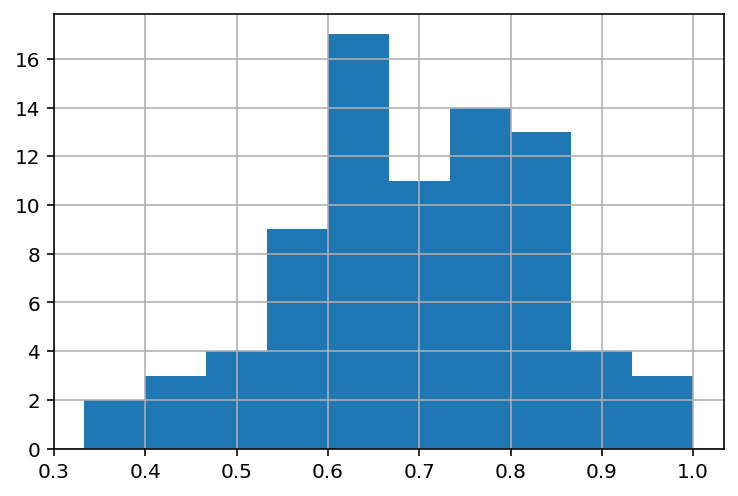

In [8]:
df['tapn'] = df['ttt'].apply(lambda x: get_apn(x, ytvs, fold='ttt'))
df['tapn'].apply(lambda r: get_apn_acc(*r)).hist()
df['tapn'].apply(lambda r: get_apn_acc(*r)).mean()

In [9]:
from itertools import chain
ttt = np.vstack(list(chain(df['ttt'])))
vtt = np.vstack(list(chain(df['vtt'])))
stt = np.vstack(list(chain(df['stt'])))

In [10]:
def load_all_embs(path, models, dim, arch=None, seeds=None):
    emb, folds = {}, ['train', 'valid', 'test']
    for model in models:
        if model not in emb: emb[model] = {}
        model_path = '/'.join([path, model, arch]) if arch else '/'.join([path, model])
        if seeds is not None:
            for seed in seeds:
                if model not in emb[model]: emb[model][seed] = {}
                for fold in folds:
                    if fold not in emb[model][seed]: emb[model][seed][fold] = {}
                    emb[model][seed][fold] = pickle.load(
                        open(f'{model_path}_{fold}_emb{dim}_s{seed}.pkl', 'rb'))
        else:
            for fold in folds:
                if fold not in emb[model]: emb[model][fold] = {}
                emb[model][fold] = pickle.load(
                    open(f'{model_path}_{fold}_emb{dim}.pkl', 'rb'))
    return emb

In [11]:
def get_dst_from_embs(embs):
    train, test = embs['train'], embs['test']
    return euc_dist(test, train)

def get_dss_from_embs(embs):
    train, test = embs['test'], embs['test']
    return euc_dist(test, train)

In [ ]:
df = pd.read_csv('../bm_prolific_d50_e50_pre_no_aug_0.csv')
df['model'] = df['Name'].map(lambda x: x.split('s')[0])
df['perf'] = df['test_clf_acc'] + df['test_triplet_acc']
df = df.loc[df.groupby('model')['perf'].idxmax()][['model', 'Name', 'perf', 'test_clf_acc', 'test_triplet_acc']]
best = {k:int(v) for k, v in df.Name.str.split('s')}
agent = 's'.join(['MTL0', str(best['MTL0'])])

In [140]:
path = '../embeds/bm/prolific/bm_prolific_d512_e50/pre_no_aug_0'
models = [f'MTL{l}' for l in [0, 0.2, 0.5, 0.8, 1]]
seeds = list(range(5))
embs = load_all_embs(path, models, 512, 'MTL_han', seeds)
dsts = {}
for model in models:
    for seed in seeds:
        name = 's'.join([model, str(seed)])
        dsts[name] = get_dst_from_embs(embs[model][seed])
b_embs = {m: embs[m][best[m]] for m in embs}

In [157]:
syns = {k: v for k, v in dsts.items() if 'MTL0s' in k}
syns['lpips.alex'] = pickle.load(open('../embeds/lpips/bm/lpips.alex.dstt.pkl', 'rb'))
syns['lpips.vgg'] = pickle.load(open('../embeds/lpips/bm/lpips.vgg.dstt.pkl', 'rb'))
b_syns = {s: syns[s] for s in [agent, 'lpips.alex', 'lpips.vgg']}
syns.keys(), len(syns)

(dict_keys(['MTL0s0', 'MTL0s1', 'MTL0s2', 'MTL0s3', 'MTL0s4', 'lpips.alex', 'lpips.vgg']),
 7)

In [162]:
model, seed = 'MTL1', best[model]
z_train, z_test = embs[model][seed]['train'], embs[model][seed]['test']
resn_nis = get_NI(z_train, y_train, z_test, y_test)

In [164]:
id_columns = ['agent', 'model', 'seed']
ds_columns = ['NINO_ds_acc', 'NIFO_ds_acc', 'rNINO_ds_acc']
er_columns = ['NINO_ds_err', 'NIFO_ds_err', 'rNINO_ds_err']
ni_columns = ['NIs', 'NI_acc']
results = pd.DataFrame(columns=id_columns + ds_columns + er_columns + ni_columns)
for syn in syns:
    syn_dist = syns[syn]
    for model in models:
        for seed in seeds:
            z_train, z_test = embs[model][seed]['train'], embs[model][seed]['test']
            evals = syn_evals(z_train, y_train, z_test, y_test, None, None, None, None, dist=syn_dist)
            nn_mat = np.vstack([np.arange(len(y_test)), evals['NIs'], resn_nis]).T
            NI_acc = (get_ds_choice(syn_dist, nn_mat) == 0).mean()
            evals['NI_acc'] = NI_acc
            results.loc[len(results)] = [syn, model, seed] \
                + [evals[k] for k in ds_columns] \
                + [evals[k] for k in er_columns] \
                + [evals[k] for k in ni_columns]

In [207]:
df = results.copy()
df = df.drop(df[df.agent.str.contains("MTL") & ~df.agent.str.contains("s4")].index)
for k, v in best.items():
    df = df.drop(df[(df['model']==k) & ~(df['seed'] == v)].index)
df = df.drop(df[(df['agent']=='MTL0') & ~(df['seed'] == best['MTL0'])].index)
df_best = df.copy()
df_agent = results[results['agent'] == agent].copy()
df_agent_best = df_agent.loc[[
    i for i in df_best.index if i in df_agent.index]].copy()

In [167]:
def get_ci(samples, confidence=0.95):
    from scipy import stats
    return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)
df_mean = results.groupby(['agent', 'model']).agg(
    {c: 'mean' for c in ds_columns}).reset_index()
df_sems = results.groupby(['agent', 'model']).agg(
    {c: get_ci for c in ds_columns}).reset_index()
def get_df_mean_sems(df_mean, df_sems, agent=None):
    if agent is not None:
        df_mean = df_mean[df_mean['agent'] == agent]
        df_sems = df_sems[df_sems['agent'] == agent]
    columns = ['NINO_ds_acc', 'NIFO_ds_acc', 'rNINO_ds_acc']
    df_mean_sems = df_mean.copy()
    df_mean_sems[columns] = df_mean[columns].applymap("{:.3f} ± ".format)
    df_mean_sems[columns] += df_sems[columns].applymap("{:.3f}".format)
    return df_mean_sems
get_df_mean_sems(df_mean, df_sems).head()

,agent,model,NINO_ds_acc,NIFO_ds_acc,rNINO_ds_acc
0,MTL0s0,MTL0,0.770 ± 0.119,1.000 ± 0.000,0.815 ± 0.239
1,MTL0s0,MTL0.2,0.795 ± 0.142,1.000 ± 0.000,0.825 ± 0.124
2,MTL0s0,MTL0.5,0.775 ± 0.076,1.000 ± 0.000,0.785 ± 0.083
3,MTL0s0,MTL0.8,0.810 ± 0.094,1.000 ± 0.000,0.805 ± 0.081
4,MTL0s0,MTL1,0.855 ± 0.135,0.860 ± 0.235,0.850 ± 0.088


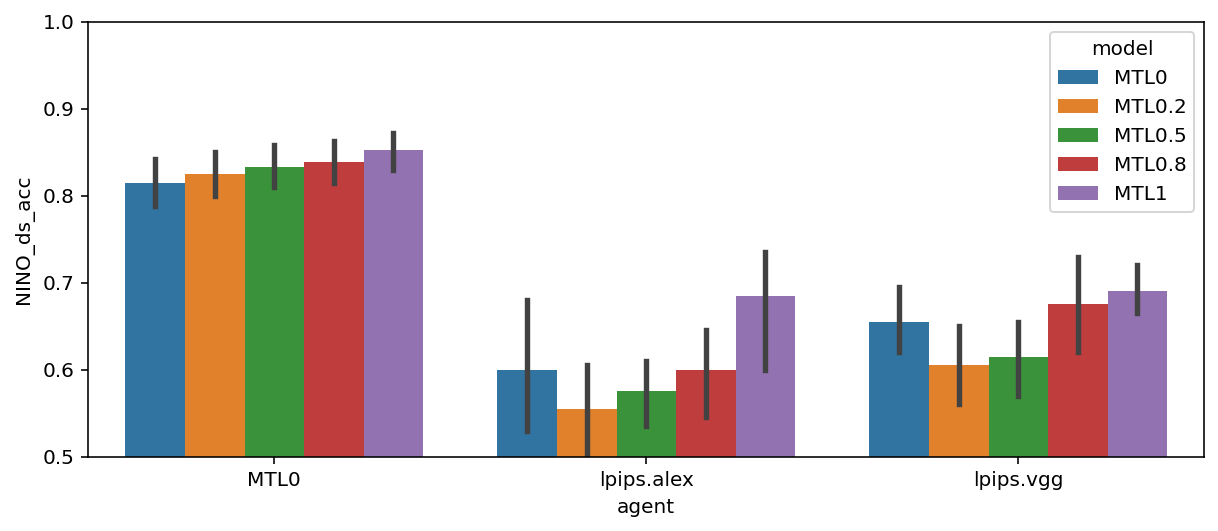

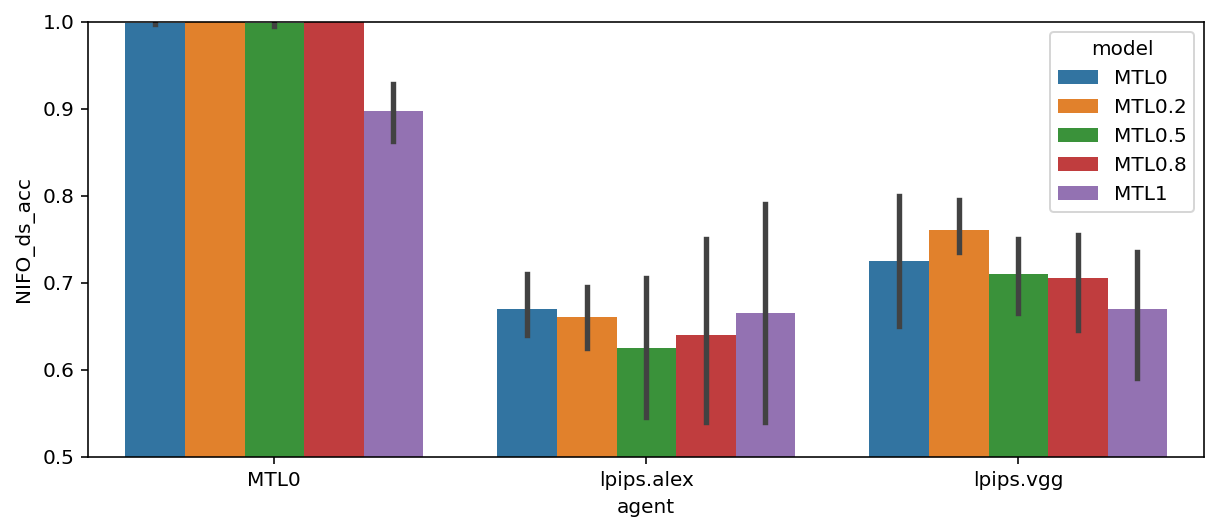

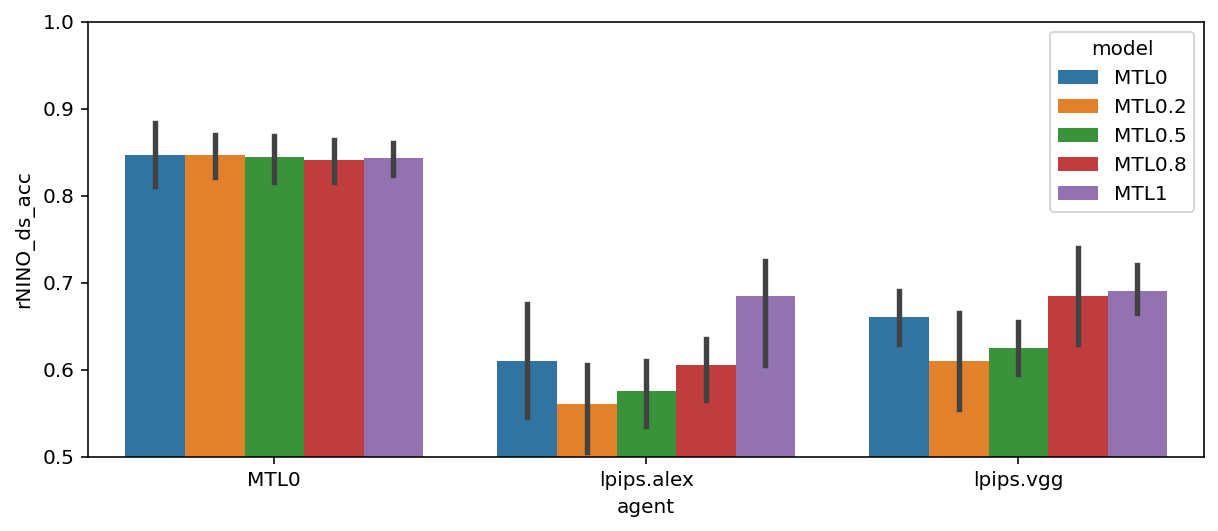

In [168]:
for ds in ds_columns:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    df = results[id_columns + [ds]].copy()
    df['agent'] = df['agent'].apply(lambda x: x.split('s')[0] if 'MTL0' in x else x)
    sns.barplot(ax=ax, x='agent', y=ds, hue='model', data=df)
    ax.set_ylim((0.5, 1))

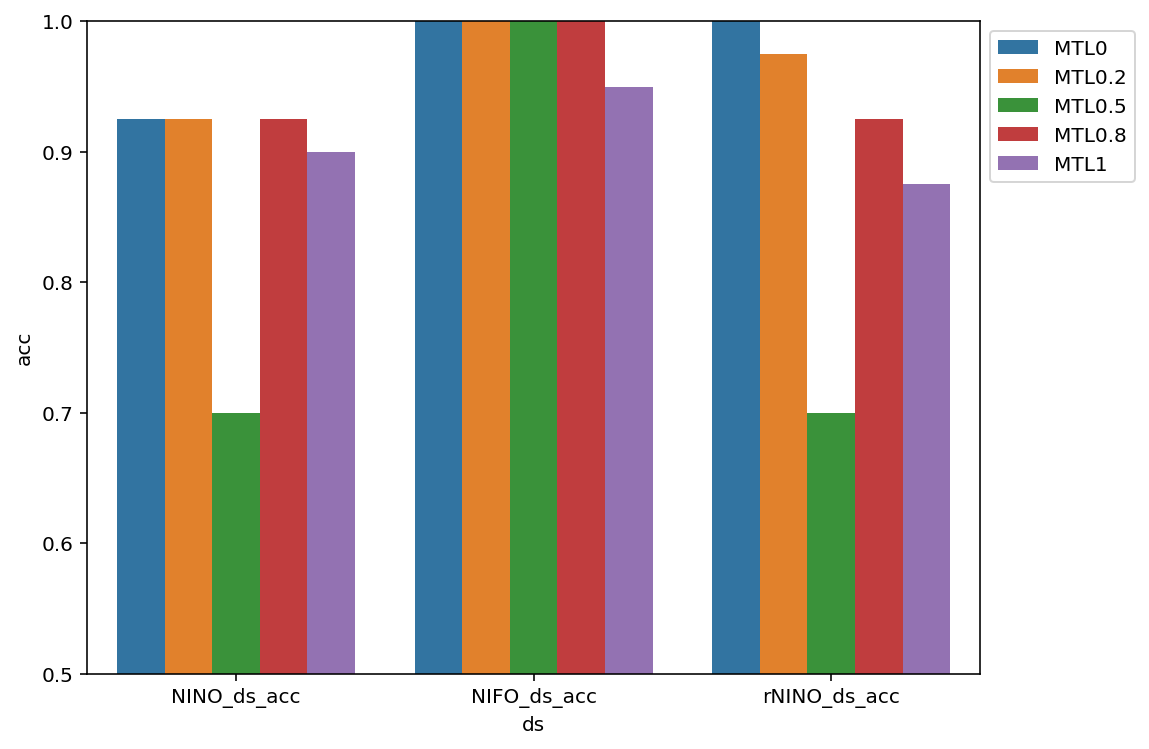

In [169]:
df = df_best.copy()
df = df[df['agent'] == agent]
df_melt = pd.melt(df, id_columns, ds_columns, var_name='ds', value_name='acc')
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.barplot(ax=ax, x='ds', y='acc', hue='model', data=df_melt)
ax.set_ylim((0.5, 1)); ax.legend(bbox_to_anchor=(1,1))

In [150]:
def eval_stt(dist, stt):
    dist = dist[stt[:, 0]]
    ap = np.take_along_axis(dist, stt[:, 1:2], 1)
    an = np.take_along_axis(dist, stt[:, 2:], 1)
    return (ap < an).mean()


,agent,test_triplet_acc
0,MTL0,0.72125
1,MTL0,0.71000
2,MTL0,0.72125
3,MTL0,0.74625
4,MTL0,0.74750
5,lpips.alex,0.54500
6,lpips.vgg,0.55000


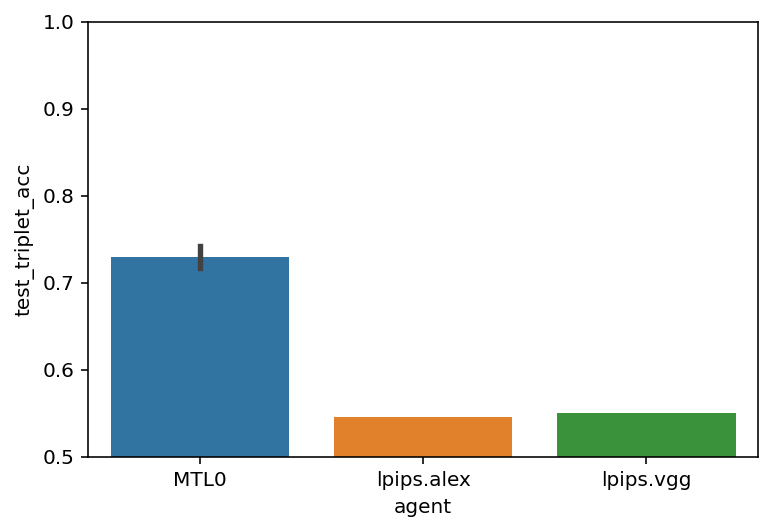

In [152]:
df = pd.DataFrame(columns=["agent", "test_triplet_acc"])
for syn in syns:
    df.loc[len(df)] = [syn, eval_stt(syns[syn], stt)]
df['agent'] = df['agent'].apply(lambda x: x.split('s')[0] if 'MTL0' in x else x)
ax = sns.barplot(data=df, x='agent', y='test_triplet_acc')
ax.set_ylim((0.5, 1))
df

In [148]:
b_dists = {m: get_dst_from_embs(b_embs[m]) for m in b_embs}
b_nis = df_best.groupby('model').agg({'NIs': 'first'}).to_dict()['NIs']
for k in b_nis:
    nn_mat = np.vstack([np.arange(len(y_test)), b_nis[k], b_nis['MTL1']]).T
    NI_acc = (get_ds_choice(syns[agent], nn_mat) == 0).mean()
    print(k, NI_acc)

MTL0 1.0
MTL0.2 0.875
MTL0.5 0.5
MTL0.8 0.675
MTL1 1.0


(0.5, 1.0)

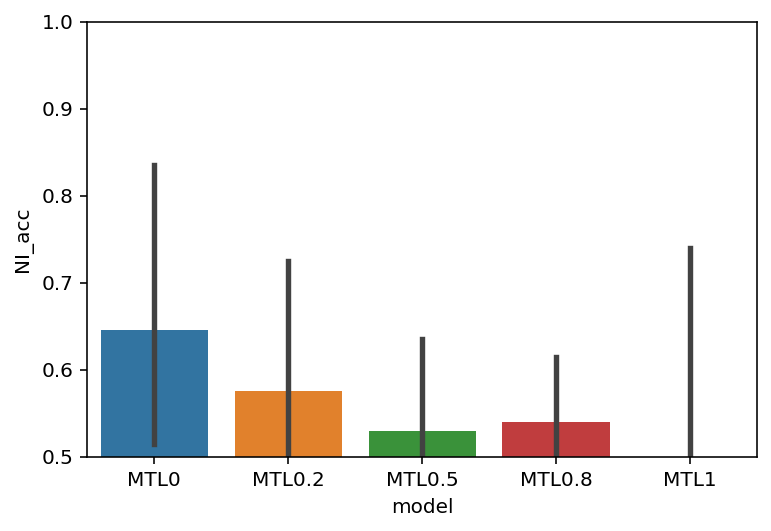

In [202]:
df = df_agent[id_columns + ['NI_acc']]
ax = sns.barplot(data=df, x='model', y='NI_acc')
ax.set_ylim((0.5, 1))

In [212]:
df = df_agent_best[id_columns + ['NI_acc']]
df[id_columns + ['NI_acc']]

,agent,model,seed,NI_acc
104,MTL0s4,MTL0,4,1.000
109,MTL0s4,MTL0.2,4,0.875
110,MTL0s4,MTL0.5,0,0.500
119,MTL0s4,MTL0.8,4,0.675
124,MTL0s4,MTL1,4,1.000


In [201]:
df_agent[id_columns + ['NI_acc']]

,agent,model,seed,NI_acc
100,MTL0s4,MTL0,0,0.625
101,MTL0s4,MTL0,1,0.575
102,MTL0s4,MTL0,2,0.600
103,MTL0s4,MTL0,3,0.425
104,MTL0s4,MTL0,4,1.000
105,MTL0s4,MTL0.2,0,0.550
106,MTL0s4,MTL0.2,1,0.550
107,MTL0s4,MTL0.2,2,0.450
108,MTL0s4,MTL0.2,3,0.450
109,MTL0s4,MTL0.2,4,0.875
